# Description

The projects goal is to build two convolutional neural network models on datasets CIFAR and MNIST, then create a function that will add different noises to the images from the datasets, and check whether the previously created and taught models will still remain accurate despite the added noise. I use datasets CIFAR and MNIST to see if there will be the difference between black&white images (that is MNIST dataset) and the coloured ones (from CIFAR) after noising them, and which noise will make the biggest change for which type of images. 

# Libraries

In [4]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from skimage.util import random_noise
from torch.utils.data import TensorDataset

# CIFAR-10 Dataset

In [2]:
BATCH_SIZE = 100 #60000 pictures total

train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([100, 3, 32, 32])
Image label dimensions: torch.Size([100])
Image batch dimensions: torch.Size([100, 3, 32, 32])
Image label dimensions: torch.Size([100])


# Hyperparameters

In [7]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 13

NUM_FEATURES = 32*32 
NUM_CLASSES = 10

DEVICE=torch.device("cpu")
GREY=True #for black&white pictures

# Model Architecture

In [5]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            
            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5), #32x32->28x28 cause kernel size=5
            nn.Tanh(), #activation function from -1 to 1
            nn.MaxPool2d(kernel_size=2), #pooling that makes nx28x28->nx14x14
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5), #14x14->10x10 cause kernel size=5
            nn.Tanh(), #activation function from -1 to 1
            nn.MaxPool2d(kernel_size=2) #pooling that makes nx10x10->nx5x5
        )
# for CIFAR from 3072 values for one photo we make 1200, for MNIST we reduce it from 1024 to 400 values
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5*in_channels, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

# Model accuracy function

In [5]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device, torch.float32)
        targets = targets.to(device, torch.float32)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Model for CIFAR dataset

In [8]:
torch.manual_seed(RANDOM_SEED)

modelCIFAR = LeNet5(NUM_CLASSES)
modelCIFAR.to(DEVICE)

optimizer = torch.optim.Adam(modelCIFAR.parameters(), lr=LEARNING_RATE)  

In [6]:
torch.manual_seed(RANDOM_SEED)

modelCIFAR = LeNet5(NUM_CLASSES)
modelCIFAR.to(DEVICE)

optimizer = torch.optim.Adam(modelCIFAR.parameters(), lr=LEARNING_RATE)  

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    modelCIFAR.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = modelCIFAR(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

    modelCIFAR.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(modelCIFAR, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

torch.save(modelCIFAR, "modelCIFAR")

Epoch: 001/013 | Batch 0000/0500 | Cost: 2.3123
Epoch: 001/013 | Batch 0050/0500 | Cost: 1.7879
Epoch: 001/013 | Batch 0100/0500 | Cost: 1.6376
Epoch: 001/013 | Batch 0150/0500 | Cost: 1.4353
Epoch: 001/013 | Batch 0200/0500 | Cost: 1.5052
Epoch: 001/013 | Batch 0250/0500 | Cost: 1.3939
Epoch: 001/013 | Batch 0300/0500 | Cost: 1.3575
Epoch: 001/013 | Batch 0350/0500 | Cost: 1.5022
Epoch: 001/013 | Batch 0400/0500 | Cost: 1.5073
Epoch: 001/013 | Batch 0450/0500 | Cost: 1.4179
Epoch: 001/013 | Train: 52.762%
Time elapsed: 2.75 min
Epoch: 002/013 | Batch 0000/0500 | Cost: 1.4024
Epoch: 002/013 | Batch 0050/0500 | Cost: 1.2530
Epoch: 002/013 | Batch 0100/0500 | Cost: 1.3269
Epoch: 002/013 | Batch 0150/0500 | Cost: 1.2896
Epoch: 002/013 | Batch 0200/0500 | Cost: 1.2541
Epoch: 002/013 | Batch 0250/0500 | Cost: 1.1762
Epoch: 002/013 | Batch 0300/0500 | Cost: 1.2585
Epoch: 002/013 | Batch 0350/0500 | Cost: 1.2112
Epoch: 002/013 | Batch 0400/0500 | Cost: 1.1610
Epoch: 002/013 | Batch 0450/0500 

In [7]:
print('Train: %.3f%%' % (compute_accuracy(modelCIFAR, train_loader, device=DEVICE)) + " | " + 'Test: %.3f%%' % (compute_accuracy(modelCIFAR, test_loader, device=DEVICE)))

Train: 97.416% | Test: 65.520%


# MNIST dataset

In [8]:
BATCH_SIZE = 120 #70000 pictures total
resize_transform = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.ToTensor()])

train_dataset2 = datasets.MNIST(root='data', 
                               train=True, 
                               transform=resize_transform,
                               download=True)

test_dataset2 = datasets.MNIST(root='data', 
                              train=False, 
                              transform=resize_transform)


train_loader2 = DataLoader(dataset=train_dataset2, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader2 = DataLoader(dataset=test_dataset2, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

for images, labels in train_loader2:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([120, 1, 32, 32])
Image label dimensions: torch.Size([120])


# Model for MNIST dataset

In [9]:
torch.manual_seed(RANDOM_SEED)

modelMNIST = LeNet5(NUM_CLASSES, GREY)
modelMNIST.to(DEVICE)

optimizer = torch.optim.Adam(modelMNIST.parameters(), lr=LEARNING_RATE) 

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    modelMNIST.train()
    for batch_idx, (features, targets) in enumerate(train_loader2):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = modelMNIST(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader2), cost))

    modelMNIST.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(modelMNIST, train_loader2, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

torch.save(modelMNIST, "modelMNIST")

Epoch: 001/013 | Batch 0000/0500 | Cost: 2.3053
Epoch: 001/013 | Batch 0050/0500 | Cost: 0.5159
Epoch: 001/013 | Batch 0100/0500 | Cost: 0.3399
Epoch: 001/013 | Batch 0150/0500 | Cost: 0.2679
Epoch: 001/013 | Batch 0200/0500 | Cost: 0.1565
Epoch: 001/013 | Batch 0250/0500 | Cost: 0.1472
Epoch: 001/013 | Batch 0300/0500 | Cost: 0.2565
Epoch: 001/013 | Batch 0350/0500 | Cost: 0.1295
Epoch: 001/013 | Batch 0400/0500 | Cost: 0.0990
Epoch: 001/013 | Batch 0450/0500 | Cost: 0.2278
Epoch: 001/013 | Train: 97.147%
Time elapsed: 0.83 min
Epoch: 002/013 | Batch 0000/0500 | Cost: 0.1643
Epoch: 002/013 | Batch 0050/0500 | Cost: 0.0766
Epoch: 002/013 | Batch 0100/0500 | Cost: 0.1456
Epoch: 002/013 | Batch 0150/0500 | Cost: 0.0439
Epoch: 002/013 | Batch 0200/0500 | Cost: 0.0770
Epoch: 002/013 | Batch 0250/0500 | Cost: 0.0695
Epoch: 002/013 | Batch 0300/0500 | Cost: 0.0311
Epoch: 002/013 | Batch 0350/0500 | Cost: 0.0360
Epoch: 002/013 | Batch 0400/0500 | Cost: 0.0478
Epoch: 002/013 | Batch 0450/0500 

In [10]:
print('Train: %.3f%%' % (compute_accuracy(modelMNIST, train_loader2, device=DEVICE)) + " | " + 'Test: %.3f%%' % (compute_accuracy(modelMNIST, test_loader2, device=DEVICE)))

Train: 99.800% | Test: 98.680%


# Function for noising the images

In [11]:
def noise(dataset, type: str):
    torch.manual_seed(42)
    
    noisy_data = []
    for data in dataset:
        img, _ = data[0], data[1]
        if type=="gaussian":
            noisy_data += torch.tensor(random_noise(img, mode=type, mean=0, var=0.05, clip=True))
        else:
            noisy_data += torch.tensor(random_noise(img, mode=type, clip=True))
            
    if 'loader' in str(dataset):
        tensor_sequence = torch.stack(noisy_data)
        BATCH_SIZE=100
    else:
        tensor_sequence = torch.stack(noisy_data).unsqueeze(1)
        BATCH_SIZE=120
        
    labels_list = []
    for _, labels in dataset:
        labels_list.append(labels)
    labels_tensor = torch.cat(labels_list)

    train = DataLoader(dataset=TensorDataset(tensor_sequence, labels_tensor), batch_size=BATCH_SIZE, shuffle=False)
    
    return train

In [12]:
def calculate_noise(ilosc: list, dataloader):
    images=[]
    Probability=[]
    types=list(['gaussian', 'localvar', 'poisson', 'salt', 'pepper', 's&p', 'speckle'])
    for n in ilosc:
        for i in range(len(types)):
            for batch_idx, (features, targets) in enumerate(noise(dataloader, types[i])):
    
                features = features.to(torch.float32)
                targets = targets.to(torch.float32)
                break
    
        
            nhwc_img = np.transpose(features[n], axes=(1, 2, 0))
            nhw_img = nhwc_img.numpy()
            images.append(nhw_img)
            
            if dataloader == test_loader2:
                logits, probas = modelMNIST(features.to(DEVICE)[n, None])
            else:
                logits, probas = modelCIFAR(features.to(DEVICE)[n, None])
                
            Probability.append(probas[0][int(targets[n])]*100)
        
    return images, Probability

# Plotting noisy images

In [13]:
def plot_noise(ilosc, dataloader):
    images, Probability = calculate_noise(ilosc, dataloader)
    types=list(['gaussian', 'localvar', 'poisson', 'salt', 'pepper', 's&p', 'speckle'])
    for m in range(len(ilosc)):
        a=m*len(types)

        fig, axs = plt.subplots(1, int(len(images)/len(ilosc)), figsize=(15, 5))  # Tworzy 1 wiersz i len(images) kolumn

        for ax in axs:
            ax.imshow(images[a], cmap='Greys')
            ax.axis('off')
            ax.set_title(types[a%7] + ": " + str(round(float(Probability[a]), 3)))
            a=a+1
        
    plt.show()

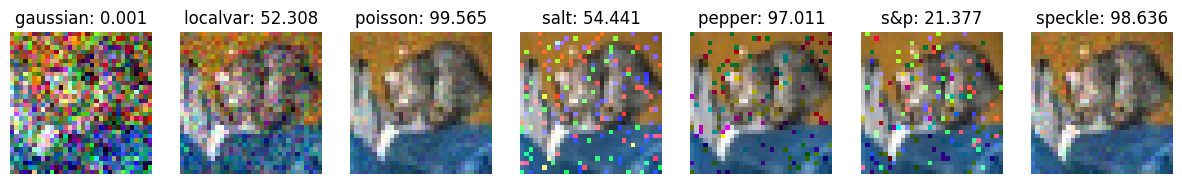

In [14]:
plot_noise([0], test_loader)

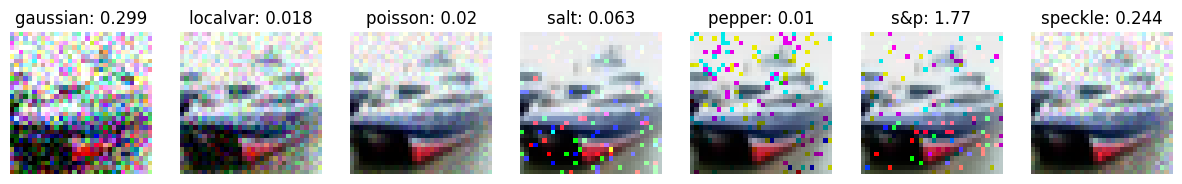

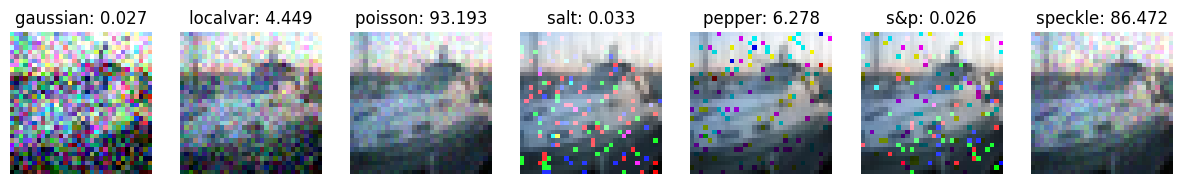

In [15]:
plot_noise([1, 2], test_loader)

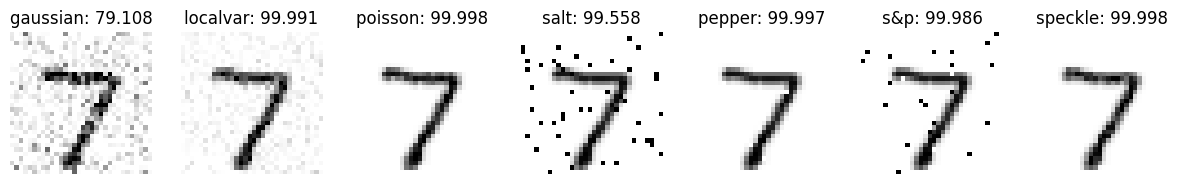

In [16]:
plot_noise([0], test_loader2)

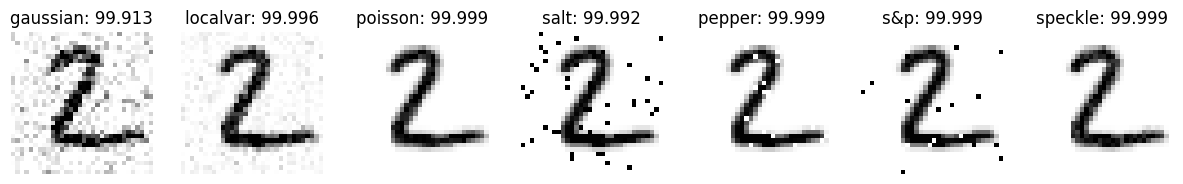

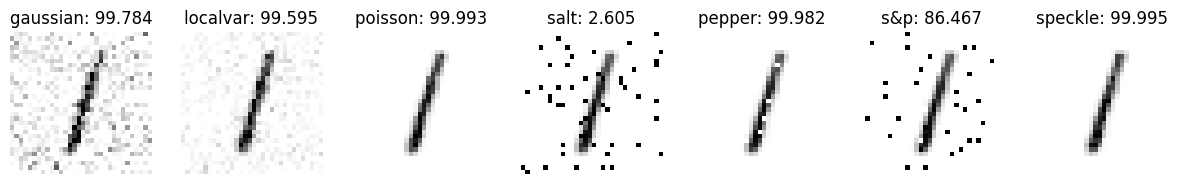

In [17]:
plot_noise([1,2], test_loader2)

# Accuracy for noisy images

In [22]:
def noise_accuracy(dataloader):
    df = pd.DataFrame()
    types = list(['gaussian', 'localvar', 'poisson', 'salt', 'pepper', 's&p', 'speckle'])
    for i in range(len(types)):
        data = noise(dataloader, types[i])
        if dataloader == test_loader2:
            df['Test'] = ['%.3f%%' % (compute_accuracy(modelMNIST, dataloader, device=torch.device("cpu")))]
            acc = compute_accuracy(modelMNIST, data, device=torch.device("cpu"))
        else:
            df['Test'] = ['%.3f%%' % (compute_accuracy(modelCIFAR, dataloader, device=torch.device("cpu")))]
            acc = compute_accuracy(modelCIFAR, data, device=torch.device("cpu"))
        df[types[i]] = ['%.3f%%' % (acc.cpu().numpy())]
    return df

In [23]:
noise_accuracy(test_loader)

,Test,gaussian,localvar,poisson,salt,pepper,s&p,speckle
0,65.520%,30.590%,54.880%,64.370%,49.240%,51.080%,49.070%,63.640%


In [24]:
noise_accuracy(test_loader2)

,Test,gaussian,localvar,poisson,salt,pepper,s&p,speckle
0,98.680%,89.370%,97.580%,98.660%,90.410%,98.360%,95.030%,98.620%
